# Numeric Integration
<style type="text/css">
  .reveal p {
    text-align: left;
  }
  .reveal ul {
    display: block;
  }
  .reveal ol {
    display: block;
  }
</style>

In [1]:
using Gadfly 
set_default_plot_size(12inch, 6inch) #set size
#make lines and points thicker and bigger labels
Gadfly.push_theme(Theme(major_label_font_size=20pt,minor_label_font_size=14pt,key_label_font_size=16pt,
                        line_width=2pt,point_size=3pt))

## A General Approach
* Problem: We have a function $f$ how do we compute
$$
\int_a^b f(x)dx
$$

* Solution:
  * Evaluate $f$ at a finite number of points $x_i$

  * Construct weights $w_i$

* Approximation of integral is given by
$$
  \int_a^b f(x)dx = \sum_i w_i f(x_i)
$$

* Trick is how do we construct those weights.....

## Quadrature and Interpolation
* There is a tight relationship between quadrature and interpolation

* Suppose we have construced an approximation to $f$ on $[a,b]$ via
$$
f(x) \approx \sum_i c_i \phi_i(x)
$$

* If the basis functions are easily integrated then we have 
$$
  \int_a^b f(x)dx \approx \sum_i c_i \int_a^b\phi_i(x)dx
$$
  * $c_i$ depend on linearly on $\{f(x_j)\}_j$ so weights will be constructed from $\int_a^b\phi_i(x)dx$

* If basis functions are constructed such that $c_i=f(x_i)$ then 
$$
\int_a^b f(x)dx \approx \sum_i f(x_i)\underbrace{\int_a^b\phi_i(x)dx}_{w_i}
$$


## Example: Linear Interpolation
* An example of this is linear spline interpolation with equally spaced grids

* Let $\{x_i\}$ be a set of equally spaced N points on $[a,b]$ where $x_{j+1}-x_j= h = \frac{b-a}{N-1}$

* For a given function $f$ we can easily interpolate this function with linear splines

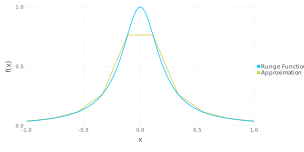

In [2]:
using BasisMatrices
f_runge(x) = 1 ./(1 .+ 25 .* x.^2) #The Runge Function
N = 10
xgrid = collect(LinRange(-1,1,10))
fhat = Interpoland(Basis(SplineParams(xgrid,0,1)),f_runge)

plot(layer(f_runge,-1,1,color=["Runge Function"]),
     layer(x->fhat(x),-1,1,color=["Approximation"]),
     Guide.ColorKey(""),Guide.xlabel("x"),Guide.ylabel("f(x)"))

* So how do we integrate the yellow line

## Example: Linear Interpolation
* We know that linear splines interpolation gives
$$
  f(x) \approx \sum_i f(x_i) B^1_i(x)
$$ where $B^1_i(x)$ are the first order B-splines.
$$
B^1_k(x) = \begin{cases}\frac{x-x_{k-1}}{x_k-x_{k-1}} & \text{ if $x_{k-1}\leq x < x_k$}\\ \frac{x_{k+1}-x}{x_{k+1}-x_k} & \text{if $x_k\leq x < x_{k+1}$}\\0&\text{otherwise}\end{cases}
$$ 
* When the $x_j$ are equally spaced we have
$$
  \int_a^b B^1_k(x)dx=\begin{cases} h &\text{if $1<j<N$} \\
                \frac{1}{2}h &\text{otherwise}\end{cases}
$$

## Example: Linear Interpolation
* So we have the integration formula
$$
\int f(x)dx \approx \frac{b-a}{N}\left(\frac{1}{2}f(x_1) + f(x_2) + f(x_3) + f(x_4) + \ldots+f(x_N)+\frac{1}{2}f(x_{N+1})\right)
$$
* Again this is easy to implement in julia

In [3]:
"""
    linear_quadrature(f,a,b,N)

Computes integral using quadrature based on linear interpolation
"""
function linear_quadrature(f,a,b,N)
    xgrid = LinRange(a,b,N)

    #Ask me: Why am I doing it like this?
    return (b-a)*(0.5*f(xgrid[1])+sum(f(x) for x in xgrid[2:end-1])+0.5*f(xgrid[end]))/N
end

linear_quadrature

## Example: Linear Interpolation
* We can see how the quadrature changes with $N$

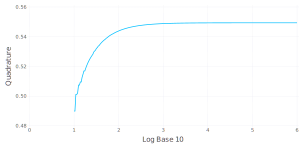

In [4]:
plot(logN->linear_quadrature(f_runge,-1,1,Int(round(10^logN))),1,6,
    Guide.xlabel("Log Base 10"),Guide.ylabel("Quadrature"))

## Simpson's Rule
* We can construct a similar rule using quadratic polynomials

* If we have three equally spaced points
  * and fit a quadratic polynomial
  * the integral is approximated by
$$
  \int_a^b f(x)dx \approx \left(\frac{1}{3}f_0 + \frac{4}{3} f_1 + \frac{1}{3}f_2\right)h
$$

* Repeating this for many small integrals we get
$$
\int_a^b f(x)dx \approx\left(\frac{1}{3}f_0+\frac{4}{3}f_1+\frac{2}{3}f_2+\frac{4}{3}f_3+\ldots+\frac{4}{3}f_{n-1}+\frac{1}{3}f_n\right)
$$


## A General Approach: Newton Cotes
* More generally if we have $n+1$ equally spaced points

* We can fit an $n$ degree polynomial

* We can then integrate that polynomial to approximate integral

* For up to an $n^th$ degree polynomial with have an exact answer
  
  * Accurate approximation if $f$ is close to an $n^th$ degree polynomial

* Can be problematic:
  
  * Remember our interpolation of the Runge function....

# Gaussian Quadrature
## Can we do better?
* Can we acheive a better approximation than Newton Cotes?

* Yes! because there's no reason to restric to equidistant points

* Under gaussian quadrature with $n$ nodes:

  * Can integrate a $(2n-1)^th$ degree polynomial exactly

  * Can accurately integrate $f$ if it is close to a $(2n-1)^th$ degree polynomial

* What black magic allows us to do this?

  * Allowing ourselves to choose the nodes arbitrarily

## Gauss-Lagrange Quadrature
* WLOG we'll integrate functions on $[-1.,1]$

* We really have $2n$ free parameters:
  * $n$ weights $w_i$ and $n$ nodes $\xi_i$.

* We'll impose that we exactly integrate $x^0,x^1,x^2,\ldots,x^{2n-1}$ 

* Pick $w_i$ and $\xi_i$ such that 
$$
\int_{-1}^1 x^jdx = \sum_i w_i \xi_i^j
$$ for all $j=1,2,\ldots,2n-1$

* A system of $2n$ equations and $2n$ unknowns

* By construction can exactly integrate $x^0,x^1,x^2,\ldots,x^{2n-1}$ 

  * Also any linear combination


## Implementing Gauss-Legrange Quadrature
* The package FastGaussQuadrature is really helpful here

In [5]:
using FastGaussQuadrature
ξ,w = gausslegendre(5)
println(ξ)
println(w);

[-0.906179845938664, -0.5384693101056831, 0.0, 0.5384693101056831, 0.906179845938664]
[0.23692688505618908, 0.47862867049936647, 0.5688888888888889, 0.47862867049936647, 0.23692688505618908]


* Can use these nodes to integrate over any interval $[a,b]$

In [6]:
"""
    gausslegendre_quadrature(f,a,b,N)

Computes integral using Gauss Legendre quadrature
"""
function gausslegendre_quadrature(f,a,b,N)
    ξ,w = gausslegendre(N)
    #Next rescale nodes to be on [a,b]
    x = ξ.*(b-a)/2 .+ b/2 .+ a/2

    #return weighted sum (note need to scale based on (b-a))
    return sum(w[i]*f(x[i]) for i in 1:N)*(b-a)/2
end;

## Quadrature Comparison

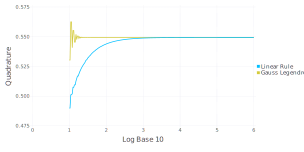

In [7]:
plot(layer(logN->linear_quadrature(f_runge,-1,1,Int(round(10^logN))),1,6,color=["Linear Rule"]),
     layer(logN->gausslegendre_quadrature(f_runge,-1,1,Int(round(10^logN))),1,6,color=["Gauss Legendre"]),
    Guide.xlabel("Log Base 10"),Guide.ylabel("Quadrature"),Guide.ColorKey(""))

* See, it pays to be smart with nodes

# Gauss-Hermite Quadrature
## Expectation of a random normal variable
* Let $h(x)$ be a function of random normal variable $x$

  * $x\sim\mathcal N(\mu,\sigma^2)$

* How do we compute 
$$
\mathbb E[h(x)] = \int_{-\infty}^\infty \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)h(x)dx?
$$

* Gauss-Hermite quadrature will be our tool

## Gause-Hermite Quadrature
* Suppose we want to approximate 
$$
\int f(x)e^{-x^2}dx \text{ with }\sum_i w_if(\xi_i)
$$

* The function $e^{-x^2}$ is a *weighting function* and is caputred by the $w_i$ coefficients

* Lot's of different weighting functions can be used
  * depends on application

  * for infinite domains need to got to 0 fast enough in the limit

* For Gauss-Hermite Quadrature find $w_i$ and $\xi_i$ that solve
$$
  \int_{-\infty}^\infty x^j e^{-x^2}dx = \sum_i w_i \xi_i^j
$$for $j=0,1,\ldots,2n-1$

## Expectations of Normal Variabes
* For a function $h(y)$ we had 
$$
\mathbb E[h(y)] = \int_{-\infty}^\infty \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)h(y)dy
$$

* We know how to compute
$$
\int f(x)e^{-x^2}dx 
$$
using Gauss-Hermite Quadrature

* These are close but not exactly the same 

    * A change of variables will do the trick

## Change of Variables
* Start with
$$
\mathbb E[h(y)] =\int_{-\infty}^\infty \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{(y-\mu)^2}{2\sigma^2}\right)h(y)dy
$$
* Let $x=\frac{y-\mu}{\sqrt{2}\sigma}$ then $y=\mu + \sqrt{2}\sigma x$ and $dy = \sqrt{2}\sigma dx$
* Then 
$$
\mathbb E[h(y)] = \int_{-\infty}^\infty \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-x^2\right)h(\mu + \sqrt{2}\sigma x)\sqrt{2}\sigma dx
$$
* Or
$$
\mathbb E[h(y)] = \int_{-\infty}^\infty \frac{1}{\sqrt{\pi}}\exp\left(-x^2\right)h(\mu + \sqrt{2}\sigma x) dx
$$
* We can now solve approximate this using Gauss-Hermite quadrature by setting $f(x)\equiv h(\mu + \sqrt{2}\sigma x)$

## How to Approximate Expectations of a Normal Variable
* Obtain $n$ Gauss-Hermite quadrature nodes and weights: $\xi_i$,$w_i$ 

* Calculate expectation using 
$$
\mathbb E[h(y)] \approx \frac{1}{\sqrt{\pi}}\sum_i w_i h\left(\sqrt{2} \sigma\xi_i+\mu\right)
$$

* Remember the $\sqrt\pi$!

## Implementation

In [8]:
"""
    expectation_normal(h,μ,σ,N)

Compute the expectation of a function h(y) of a normal variable y∼N(μ,σ) using
N point Gauss-Hermite quadrature
"""
function expectation_normal(h,μ,σ,N)
    ξ,w = gausshermite(N)
    x = sqrt(2).*σ.*ξ .+ μ

    return sum(w[i]*h(x[i]) for i in 1:N)/sqrt(pi)
end;

## Example: Log Normal
* Suppose that $h(y) = exp(y)$ then $\mathbb E[h(y)]$ is the expectation of a log normal variable

  * We know the answer is $E[h(y)] = \exp(\mu + 0.5 \sigma^2)$

* We can see how quickly quadrature converges to the answer

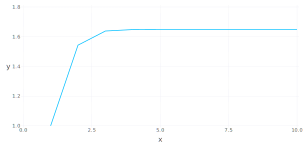

In [9]:
plot(x=1:10,y=expectation_normal.(exp,0.,1.,1:10),Geom.line)

* We compare this to the truth $\exp(0.5)=$ `j exp(0.5)`

# Higher Dimensional Quadrature

## A Curse of Dimensionality (again)
* Easy to extend quadrature rules to a higher dimensions using Fubini's Theorem
$$
  \int_{X\times Y}f(x,y)d(x,y)=\int_X\int_Yf(x,y)dydx
$$

  * Let $\xi_i^X$,$w_i^X$ be the nodes and weights over $X$
  * Let $\xi_j^Y$,$w_j^Y$ be the nodes and weights over $Y$

*  Applying Fubini's Theorem we get
\begin{align}
\int_{X\times Y}f(x,y)d(x,y) & = \int_X\int_Yf(x,y)dydx\\
                             & \approx \int_X \sum_jw_j^Yf(x,\xi_j^Y)dx\\
                             & \approx \sum_i\sum_jw_i^Xw_j^Yf(\xi_i^X,\xi_j^Y)dx
\end{align}

## Higher Order Quadrature 
* Nesting this algroithm we can see that if we have $N$ nodes per dimension
  * then integrating a function $f$ of $D$ dimensions will require $N^D$ eqvaluations
  * can get expensive fast

*  Quadrature in higher dimensions still a list of nodes $\{\xi_i\}$ and weights $\{w_i\}$
  * Nodes $\xi_i$ are constructed from quadrature nodes on each dimension: $\xi^X_i$ and $\xi^Y_i$

  * Weights are $w_i$ are construced from the quadrature weights on each dimension 

* Here the Kronecker Product will be our friend

* If $A$ and $B$ are matrices we define
$$
  A\otimes B = \left[\begin{matrix}a_{11}B&\cdots&a_{1n}B\\ \vdots&\ddots&\vdots\\ a_{m1}B&\cdots&a_{mn}B\end{matrix}\right]
$$

## 2 Dimensional Quadrature
* We can see how this looks in two dimensions

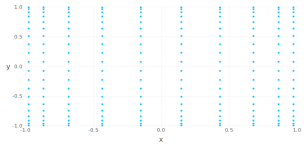

In [10]:
ξx,wx = gausslegendre(10)
ξy,wy = gausslegendre(20)

ξ = hcat(kron(ones(length(ξy)),ξx),kron(ξy,ones(length(ξx))))
w = kron(wy,wx)

plot(x=ξ[:,1],y=ξ[:,2])

## Applying to Higher Order

In [11]:
"""
    gausslegendre_quadrature(f,a,b,N)

Computes integral using Gauss Legendre quadrature
"""
function gausslegendre_quadrature(f,a::Vector,b::Vector,N::Vector)
    D = length(N)
    #dimension 1
    ξ,W = gausslegendre(N[1])
    X = ξ.*(b[1]-a[1])/2 .+ b[1]/2 .+ a[1]/2 #X is going to be an N^D×D vector

    for i in 2:D
        ξ,w = gausslegendre(N[i])
        #Next rescale nodes to be on [a,b]
        x = ξ.*(b[i]-a[i])/2 .+ b[i]/2 .+ a[i]/2

        X = hcat(kron(ones(N[i]),X),kron(x,ones(size(X,1))))
        W = kron(w,W)
    end
    #return weighted sum (note need to scale based on (b-a))
    return sum(W[i]*f(X[i,:]) for i in 1:size(X,1))*prod((b.-a)./2)
end;

## Implementation
* Let's start with a higher dimensional version of our Runge function

In [12]:
using LinearAlgebra
f_runge_ND(x) = 1 /(1 + 25 * norm(x)) #The Runge Function

f_runge_ND (generic function with 1 method)

* Over two dimensions

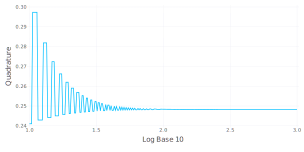

In [13]:
plot(logN->gausslegendre_quadrature(f_runge_ND,-1*ones(2),1*ones(2),Int(round(10^logN))*ones(Int,2)),1,3,
    Guide.xlabel("Log Base 10"),Guide.ylabel("Quadrature"))

* Need about 50-100 nodes in each dimension before it settels down

## 3D,4D and more
* Let's see how the cost scales with the dimension.

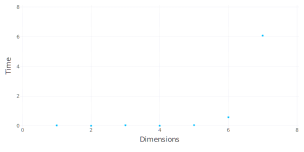

In [14]:
maxD = 7
time = zeros(maxD)
for D in 1:maxD
  time[D] = @elapsed gausslegendre_quadrature(f_runge_ND,-1*ones(D),1*ones(D),10*ones(Int,D)) 
end
plot(x=1:maxD,y=time,Guide.xlabel("Dimensions"),Guide.ylabel("Time"))

# Monte Carlo Methods
## Regular Monte Carlo
* Another tool for computing the integral of a function is monte Carlo

* Let $x$ be a random variable with CDF $F(x)$
  * Let $h$ be some function of $x$

* We can approximate
$$
\mathbb E[h(x)] = \int_a^b h(x)dF(x)
$$by drawing $T$ values of $x$

* Expectation is then approximated by sample average
$$
\int_a^b h(x)dF(x) \approx \frac1T\sum_{t=1}^T h(x_t)
$$

## Using Monte Carlo For Integration
* Suppose that we don't want to compute an expectation but instead the integral
$$
  \int_a^bh(x)dx
$$

* Define $f_{ab}$ as the density of random variable
  
  * Uniform distribution over $[a,b]$

* Then our integral is an expectation
$$
  \int_a^bh(x)dx = (b-a)\int_a^b h(x)f_{ab}(x)dx
$$

* Can can be approximated by draws from the random variable
$$
\int_a^bh(x)dx \approx (b-a)\frac1T\sum_{t=1}^T h(x_t)
$$where $x_t$ is a random number uniform on $[a,b]$

## A 1-Dimensional Example
* Let's compute the integral of `f_runge`

* We draw `100000` points evaluate `f_runge` and then take the average

In [15]:
x = rand(100000)*2 .- 1 #uniform on [-1,1]
Ef = sum(f_runge.(x))/length(x)
println(Ef*2) #don't forget to scale by (b-a)

0.5488295855697389


* Compare to

In [16]:
gausslegendre_quadrature(f_runge,-1,1,1000)

0.5493603067780058

## Higher Dimeansional Monte Carlo

In [17]:
"""
    montecarlo_integration(f,a,b,N)

Computes integral using Monte Carlo methods
"""
function montecarlo_integration(f,a::Vector,b::Vector,N)
    D = length(a)
    X = rand(D,N).*(b.-a) .+ a
    #return weighted sum (note need to scale based on (b-a))
    return sum(f(X[:,i]) for i in 1:N)/N*prod(b.-a)
end;

## Higher Dimeansional Monte Carlo: Application

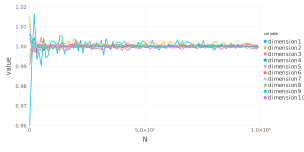

In [18]:
using DataFrames
Nmax = 10^6
dfMonte = DataFrame()
dfMonte.N = 1000:10000:Nmax
for D in 1:10
    dfMonte[!,"dimension$D"] = [montecarlo_integration(f_runge_ND,-1*ones(D),ones(D),N) for N in 1000:10000:Nmax]
    dfMonte[!,"dimension$D"] ./= dfMonte[end,"dimension$D"] #normalize by last point
end

plot(stack(dfMonte,["dimension$D" for D in 1:10]),x=:N,y=:value,color=:variable,Geom.line)

* Seems to avoid curse of dimensionality
  * But converges very slowly

## Quasi Monte Carlo
* In higher dimensional problems monte carlo methods  seem to do better than quadrature

* Why? MC is simply a deterministic (remember pseudo random) way of  going through state space

* Quasic Monte Carlo takes this idea and improves on it

  * Want to fill up space in an **efficient** way

* Define an *equidistant* series as a scalar series such that
$$
  \lim_{T\rightarrow\infty}\frac{b-a}{T}\sum_{i=1}^Tf(x_i) = \int_a^b f(x)dx
$$
  * For all Reiman-integrable functions

* We could use these *equidistant* series in place of uniform

* Example: let $\eta$ be an irrational number
  * $\eta,2\eta,3\eta,\ldots$ modulo 1

## Quasi Monte Carlo - Higher Dimensional
* Quasi Monte Carlo extends naturally to higher dimensions

* A sequence $\{x_i\}\subset M \subset \mathbb R ^D$ is *equidistant* if
$$
  \lim_{N\rightarrow\infty}\frac{\mu(M)}{N}\sum_{i=1}^Nf(x_i)=\int_Df(x)dx
$$where $\mu(M) is the Lebesque measure of $M$

* Example Weyl: $x_i = (i\sqrt{p_1},i\sqrt{p_2},\ldots,i\sqrt{p_D})$ modulo 1 
  * where $p_i$ is the $i^{th}$ prime 

* Sobol numbers are commonly used
  * Have advantage that projects to lower dimensions are also *equidistant*

## Quadrature vs Monte Carlo vs Quasi Monte Carlo

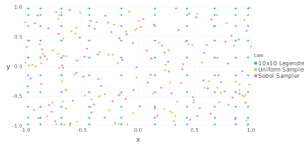

In [19]:
using QuasiMonteCarlo
ξx,wx = gausslegendre(10)
ξy,wy = gausslegendre(10)
XQuad = hcat(kron(ones(length(ξy)),ξx),kron(ξy,ones(length(ξx))))'
XUnif = rand(2,100).*2 .- 1
XSobol = QuasiMonteCarlo.sample(100,[-1,-1],[1,1],SobolSample())
plot(layer(x=XQuad[1,:],y=XQuad[2,:],color=["10x10 Legendre"]),
     layer(x=XUnif[1,:],y=XUnif[2,:],color=["Uniform Sampler"]),
     layer(x=XSobol[1,:],y=XSobol[2,:],color=["Sobol Sampler"]))

## Using Quasi Monte Carlo

In [20]:
"""
    quasi_montecarlo_integration(f,a,b,N)

Computes integral using Quasi Monte Carlo Methods
"""
function quasi_montecarlo_integration(f,a::Vector,b::Vector,N)
    X = QuasiMonteCarlo.sample(N,a,b,SobolSample())
    #return weighted sum (note need to scale based on (b-a))
    return sum(f(X[:,i]) for i in 1:N)/N*prod(b.-a)
end;

## Quasi Monte Carlo Performance

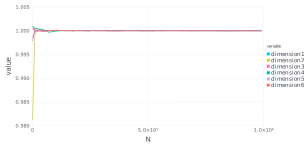

In [21]:
Nmax = 10^6
dfQMonte = DataFrame()
dfQMonte.N = 1000:10000:Nmax
for D in 1:10
    dfQMonte[!,"dimension$D"] = [quasi_montecarlo_integration(f_runge_ND,-1*ones(D),ones(D),N) for N in 1000:10000:Nmax]
    dfQMonte[!,"dimension$D"] ./= dfQMonte[end,"dimension$D"] #normalize by last point
end

plot(stack(dfQMonte,["dimension$D" for D in 1:6]),x=:N,y=:value,color=:variable,Geom.line)

# Optimal Taxation Revisited (Again)

## Another Improvement
* In our optimal taxation problem individual state $\alpha$
  * Distribution is $\mathcal N(-\sigma^2_\alpha/2,\sigma^2_\alpha)

* We were using Monte Carlo to integrate over $\alpha$
  * Used 1000 "agents"

* Can we adjust our code to use Gauss Hermite quadrature instead

  * Can it speed up the algroithm?


## Some Previous Code

In [22]:
using BasisMatrices,LinearAlgebra,Roots
σ = 2. #Standard
γ = 2. #Targets Frisch elasticity of 0.5
σ_α = sqrt(0.147) #Taken from HSV

"""
    approximate_household_labor(NlŴ,NT,σ,γ)

Approximates HH policies as a function of log after tax wage and transfers.
"""
function approximate_household_labor(NlŴ,NT,σ_α,σ,γ;scale=5)
    lŴbasis = ChebParams(NlŴ,-scale*σ_α+log(1-.8),scale*σ_α)
    Tbasis = ChebParams(NT,0.,2.) #we know optimal tax will always be positive
    basis = Basis(lŴbasis,Tbasis)
    X = nodes(basis)[1]
    N = size(X,1) #How many nodes are there?
    c,h = zeros(N),zeros(N)
    for i in 1:N 
        Ŵ,T = exp(X[i,1]),X[i,2]
        res(h) = (Ŵ*h+T)^(-σ)*Ŵ-h^γ
        min_h = max(0,(.0000001-T)/Ŵ) #ensures c>.0001
        h[i] = fzero(res,min_h,20000.) #find hours that solve HH problem
        c[i] = Ŵ*h[i]+T
    end
    U = @. c^(1-σ)/(1-σ)-h^(1+γ)/(1+γ)
    return Interpoland(basis,c),Interpoland(basis,h),Interpoland(basis,U)
end;

## Adapt Budget Constraint And Welfare

In [23]:
"""
    budget_residual(τ,T,α,w,hf)

Computes the residual of the HH budget constraint given policy (τ,T)
"""
function budget_residual(τ,T,α,w,hf)
    N = length(α)
    X = [α .+ log(1-τ)  T*ones(N)]
    tax_income = dot(w, hf(X).*exp.(α).*τ)
    return tax_income - T
end;

##  Adapt Welfare

In [24]:
"""
    government_welfare(τ,T,α,w,σ,γ)

Solves for government welfare given given policy (τ,T)
"""
function government_welfare(τ,T,α,w,Uf)
    N = length(α)
    X = [α .+ log(1-τ)  T*ones(N)]
    return dot(w,Uf(X))
end;

## Wrap NLOPT to Find Optimal Policy

In [25]:
using NLopt

""" 
    find_optimal_policy(N,σ_α,Uf,hf)

Computes the optimal policy given policy fuctions hf and indirect utility Uf
"""
function find_optimal_policy(N,σ_α,Uf,hf)
    ξ,w = gausshermite(N)
    α = sqrt(2).*σ_α.*ξ .- σ_α^2/2
    w ./= sqrt(pi) #remember sqrt(\pi)
    opt = Opt(:LN_COBYLA, 2)
    lower_bounds!(opt, [0., 0.])
    upper_bounds!(opt, [0.8,Inf])
    ftol_rel!(opt,1e-8)

    min_objective!(opt, (x,g)->-government_welfare(x[1],x[2],α,w,Uf))
    equality_constraint!(opt, (x,g) -> -budget_residual(x[1],x[2],α,w,hf))

    minf,minx,ret = NLopt.optimize(opt, [0.3, 0.3])
    if ret == :FTOL_REACHED
        return minx
    end
end
cf,hf,Uf = approximate_household_labor(20,20,σ_α,σ,γ)
find_optimal_policy(30,σ_α,Uf,hf)
@time find_optimal_policy(30,σ_α,Uf,hf)

  0.003248 seconds (5.82 k allocations: 2.218 MiB)


2-element Vector{Float64}:
 0.36754553628059927
 0.32398074509151337

* Even faster now

## How Does Policy Depend On # of Nodes?

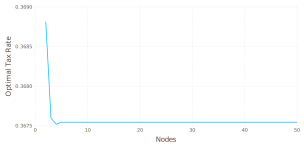

In [26]:
plot(x=2:50,y=[find_optimal_policy(N,σ_α,Uf,hf)[1] for N=2:50],Geom.line,Guide.xlabel("Nodes"),Guide.ylabel("Optimal Tax Rate"))

## Compare to Monte-Carlo

In [27]:
using Distributions
""" 
    find_optimal_policy(N,σ_α,Uf,hf)

Computes the optimal policy given policy fuctions hf and indirect utility Uf
"""
function find_optimal_policy_MC(N,σ_α,Uf,hf)
    alphaDist = Normal(-σ_α^2/2,σ_α)
    α = rand(alphaDist,N)
    w = ones(N)/N #equal weights to compute sample average 
    opt = Opt(:LN_COBYLA, 2)
    lower_bounds!(opt, [0., 0.])
    upper_bounds!(opt, [0.5,Inf])
    ftol_rel!(opt,1e-8)

    min_objective!(opt, (x,g)->-government_welfare(x[1],x[2],α,w,Uf))
    equality_constraint!(opt, (x,g) -> -budget_residual(x[1],x[2],α,w,hf))

    minf,minx,ret = NLopt.optimize(opt, [0.3, 0.3])
    if ret == :FTOL_REACHED
        return minx
    end
end;

## Compare to Monte-Carlo

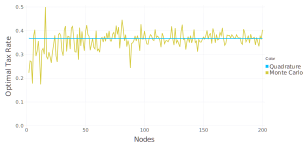

In [28]:
plot(layer(x=2:200,y=[find_optimal_policy(N,σ_α,Uf,hf)[1] for N=2:200],Geom.line,color=["Quadrature"]),
     layer(x=2:200,y=[find_optimal_policy_MC(N,σ_α,Uf,hf)[1] for N=2:200],Geom.line,color=["Monte Carlo"]),
    Guide.xlabel("Nodes"),Guide.ylabel("Optimal Tax Rate"))